In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import hijri_converter
from hijri_converter import convert
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import holidays
from datetime import datetime, timedelta
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)


In [2]:
dataset = "C://Users//LENOVO//Downloads//RevenuePassengerDailyUpdated.xlsx"
df = pd.read_excel(dataset)
df = df.rename(columns={'tanggal': 'date'})
df = df.rename(columns={'penghasilan_penumpang': 'y'})
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250855 entries, 0 to 250854
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   y         250855 non-null  int64         
 1   date      250855 non-null  datetime64[ns]
 2   org       250855 non-null  object        
 3   kode_org  250855 non-null  int64         
 4   des       250855 non-null  object        
 5   kode_des  250855 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.5+ MB


In [4]:
#aggregasi y(revenue/pax) jumlahnya lebih dari satu di (satu tanggal dan rute) yang sama **(optional)
grouped_df = df.groupby(["org","kode_org","des","kode_des"]).agg({"y": ["sum", "mean"]})

# Rename the columns
grouped_df.columns = ["total_revenue", "avg_revenue"]

# Reset the index
grouped_df = grouped_df.reset_index()

In [5]:
grouped_df

,org,kode_org,des,kode_des,total_revenue,avg_revenue
0,AGATS,948,BAU-BAU,921,473809000,5.708542e+06
1,AGATS,948,KUPANG,681,61761000,1.930031e+06
2,AGATS,948,MAKASSAR,893,293287000,5.985449e+06
3,AGATS,948,MERAUKE,979,1215058000,3.616244e+06
4,AGATS,948,SURABAYA,563,172919000,7.204958e+06
...,...,...,...,...,...,...
857,WASIOR,981,JAYAPURA,974,177057000,2.566043e+06
858,WASIOR,981,MAKASSAR,893,333747000,5.134569e+06
859,WASIOR,981,SORONG,971,117285000,1.804385e+06
860,WASIOR,981,SURABAYA,563,214664000,5.649053e+06


In [6]:
#Get list of categorical variables
s = (grouped_df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['org', 'des']


In [7]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    grouped_df[i]=grouped_df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [8]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   org            862 non-null    int32  
 1   kode_org       862 non-null    int64  
 2   des            862 non-null    int32  
 3   kode_des       862 non-null    int64  
 4   total_revenue  862 non-null    int64  
 5   avg_revenue    862 non-null    float64
dtypes: float64(1), int32(2), int64(3)
memory usage: 33.8 KB


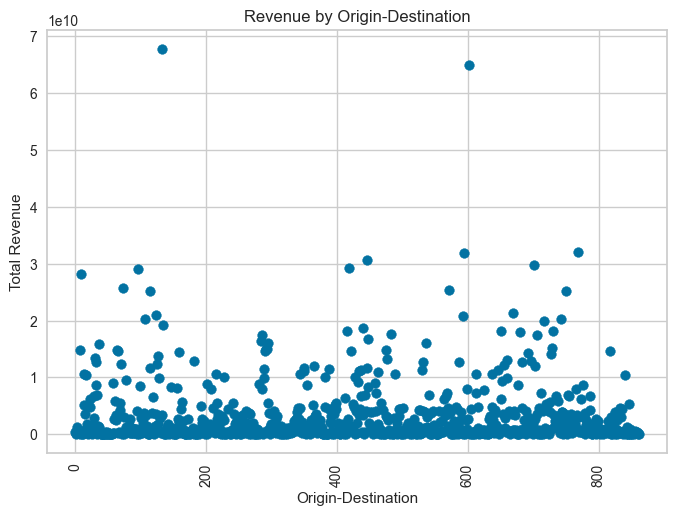

In [9]:
# Create the scatter plot
plt.scatter(grouped_df.index,grouped_df.total_revenue)

# Set labels and title
plt.xlabel('Origin-Destination')
plt.ylabel('Total Revenue')
plt.title('Revenue by Origin-Destination')

# Optionally, rotate the x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

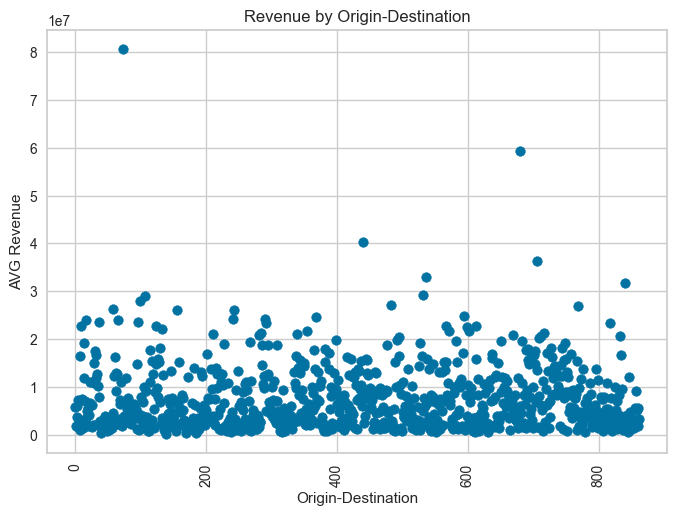

In [10]:
# Create the scatter plot
plt.scatter(grouped_df.index,grouped_df.avg_revenue)

# Set labels and title
plt.xlabel('Origin-Destination')
plt.ylabel('AVG Revenue')
plt.title('Revenue by Origin-Destination')

# Optionally, rotate the x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [11]:
ds = grouped_df.copy()
columns_to_scale = ['total_revenue', 'avg_revenue']

# Create a scaler object
scaler = StandardScaler()

# Apply feature scaling
ds.loc[:, columns_to_scale] = scaler.fit_transform(ds.loc[:, columns_to_scale])

In [12]:
ds

,org,kode_org,des,kode_des,total_revenue,avg_revenue
0,0,948,8,921,-0.461152,-0.237983
1,0,948,28,681,-0.531805,-0.785446
2,0,948,34,893,-0.492106,-0.197863
3,0,948,37,979,-0.334053,-0.541133
4,0,948,56,563,-0.512745,-0.021170
...,...,...,...,...,...,...
857,64,981,21,974,-0.512035,-0.693295
858,64,981,34,893,-0.485168,-0.321145
859,64,981,55,971,-0.522284,-0.803651
860,64,981,56,563,-0.505587,-0.246603


In [13]:
features = ds[['total_revenue','avg_revenue']]

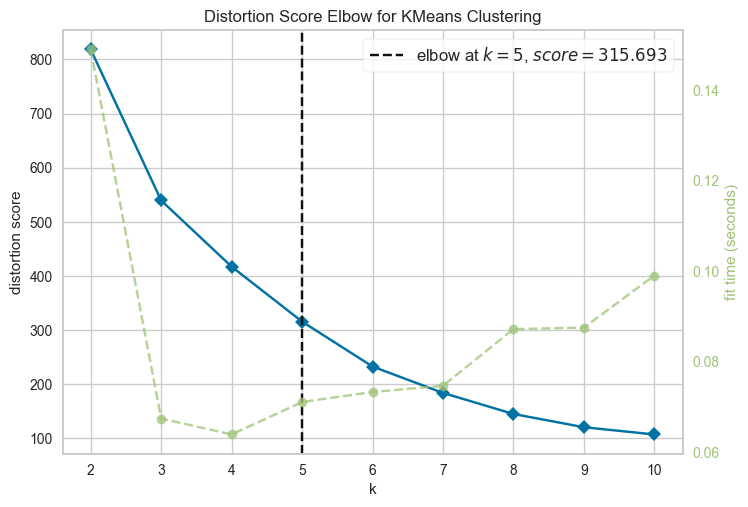

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(features)
Elbow_M.show()

In [15]:
# # Define the number of clusters
# k = 5

# # Initialize the K-means algorithm
# kmeans = KMeans(n_clusters=k, random_state=42)

# # Fit the algorithm to the PCA-transformed data
# kmeans.fit(features)

# # Get the cluster labels for each data point
# cluster_labels = kmeans.labels_

# # Add the cluster labels to the DataFrame
# ds['cluster'] = cluster_labels
# grouped_df['clusters']= cluster_labels

In [16]:
k=5
AC = AgglomerativeClustering(n_clusters=k)
# fit model and predict clusters
yhat_AC = AC.fit_predict(features)
ds['cluster'] = yhat_AC
grouped_df['clusters']= yhat_AC

In [17]:
grouped_df

,org,kode_org,des,kode_des,total_revenue,avg_revenue,clusters
0,0,948,8,921,473809000,5.708542e+06,1
1,0,948,28,681,61761000,1.930031e+06,1
2,0,948,34,893,293287000,5.985449e+06,1
3,0,948,37,979,1215058000,3.616244e+06,1
4,0,948,56,563,172919000,7.204958e+06,1
...,...,...,...,...,...,...,...
857,64,981,21,974,177057000,2.566043e+06,1
858,64,981,34,893,333747000,5.134569e+06,1
859,64,981,55,971,117285000,1.804385e+06,1
860,64,981,56,563,214664000,5.649053e+06,1


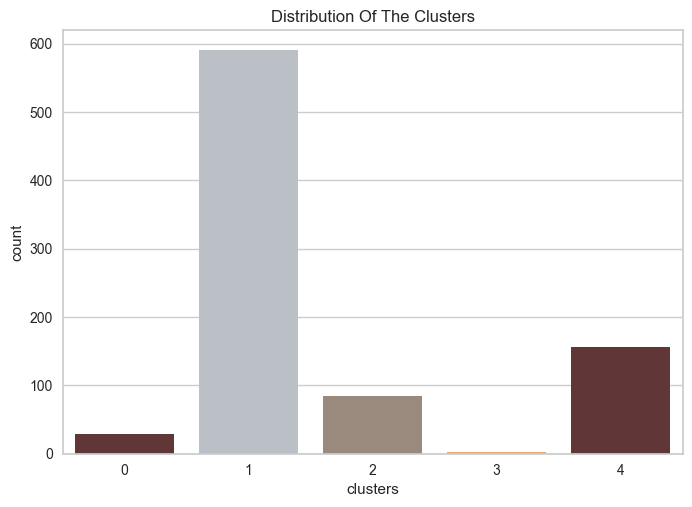

In [18]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=grouped_df["clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

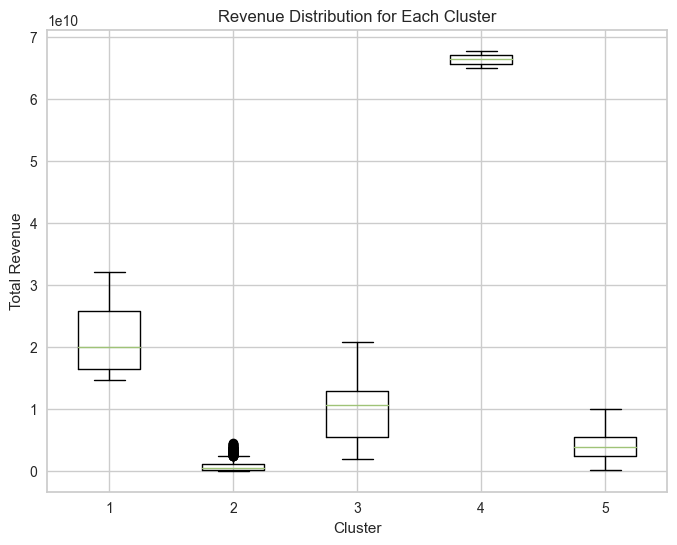

In [19]:
plt.figure(figsize=(8, 6))
plt.boxplot([grouped_df[grouped_df['clusters'] == i]['total_revenue'] for i in range(k)])
plt.xlabel('Cluster')
plt.ylabel('Total Revenue')
plt.title('Revenue Distribution for Each Cluster')
plt.show()


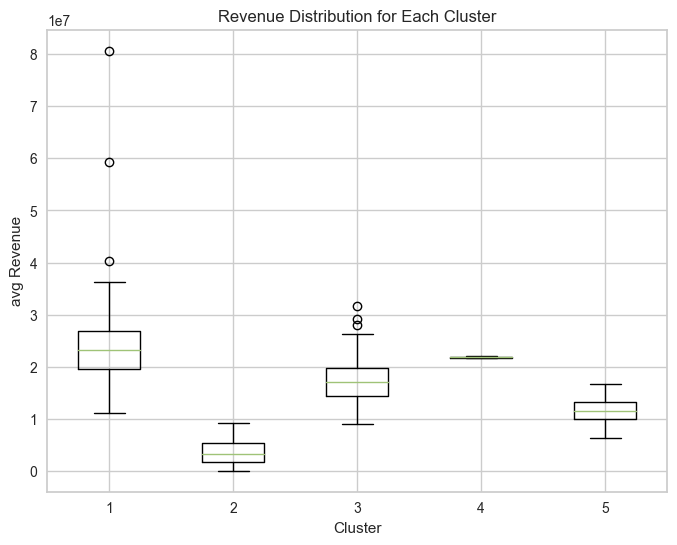

In [20]:
plt.figure(figsize=(8, 6))
plt.boxplot([grouped_df[grouped_df['clusters'] == i]['avg_revenue'] for i in range(k)])
plt.xlabel('Cluster')
plt.ylabel('avg Revenue')
plt.title('Revenue Distribution for Each Cluster')
plt.show()


In [21]:
cluster_mean_total_revenue = grouped_df.groupby('clusters')['total_revenue'].mean().sort_values()
cluster_mean_total_revenue

clusters
1    7.928140e+08
4    4.145000e+09
2    1.004885e+10
0    2.156784e+10
3    6.636721e+10
Name: total_revenue, dtype: float64

In [22]:
cluster_mean_avg_revenue = grouped_df.groupby('clusters')['avg_revenue'].mean().sort_values()
cluster_mean_avg_revenue

clusters
1    3.776734e+06
4    1.168788e+07
2    1.744273e+07
3    2.187212e+07
0    2.616081e+07
Name: avg_revenue, dtype: float64

# profiling
tipe di bagi 5 = highest , high, med, low, lowest

cluster 0 = low total , lowest avg

cluster 1 = highest total, highest avg

cluster 2 = med total , med avg

cluster 3 = lowest total, low avg

cluster 4 = high total, high avg

 # Implementasi Hasil Clustering

In [23]:
#aggregasi y(revenue/pax) jumlahnya lebih dari satu di (satu tanggal dan rute) yang sama **(optional)
grouped_df = df.groupby(["date","org","kode_org","des","kode_des"]).agg({"y": ["sum", "mean"]})

# Rename the columns
grouped_df.columns = ["total_revenue", "avg_revenue"]

# Reset the index
grouped_df = grouped_df.reset_index()
grouped_df 

,date,org,kode_org,des,kode_des,total_revenue,avg_revenue
0,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144,89848500,9.983167e+06
1,2015-08-21,TANJUNG PRIOK,431,PULAU BATAM,256,191294500,2.732779e+07
2,2015-08-21,TANJUNG PRIOK,431,TANJUNG BALAI KARIMUN,266,71755500,1.793888e+07
3,2015-08-22,PULAU BATAM,256,BELAWAN,144,181551500,1.396550e+07
4,2015-08-22,TANJUNG BALAI KARIMUN,266,BELAWAN,144,11717000,2.929250e+06
...,...,...,...,...,...,...,...
84618,2023-06-10,TERNATE,942,AMBON,946,358000,3.580000e+05
84619,2023-06-10,TERNATE,942,SURABAYA,563,534000,5.340000e+05
84620,2023-06-11,AMBON,946,SURABAYA,563,505000,5.050000e+05
84621,2023-06-11,AMBON,946,TANJUNG PRIOK,431,4920000,4.920000e+06


In [24]:
grouped_df = grouped_df.merge(ds[['kode_org', 'kode_des', 'cluster']], on=['kode_org', 'kode_des'], how='left')
grouped_df

,date,org,kode_org,des,kode_des,total_revenue,avg_revenue,cluster
0,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144,89848500,9.983167e+06,2
1,2015-08-21,TANJUNG PRIOK,431,PULAU BATAM,256,191294500,2.732779e+07,0
2,2015-08-21,TANJUNG PRIOK,431,TANJUNG BALAI KARIMUN,266,71755500,1.793888e+07,4
3,2015-08-22,PULAU BATAM,256,BELAWAN,144,181551500,1.396550e+07,3
4,2015-08-22,TANJUNG BALAI KARIMUN,266,BELAWAN,144,11717000,2.929250e+06,1
...,...,...,...,...,...,...,...,...
84618,2023-06-10,TERNATE,942,AMBON,946,358000,3.580000e+05,4
84619,2023-06-10,TERNATE,942,SURABAYA,563,534000,5.340000e+05,4
84620,2023-06-11,AMBON,946,SURABAYA,563,505000,5.050000e+05,4
84621,2023-06-11,AMBON,946,TANJUNG PRIOK,431,4920000,4.920000e+06,2


# Plot Cluster Per date+route

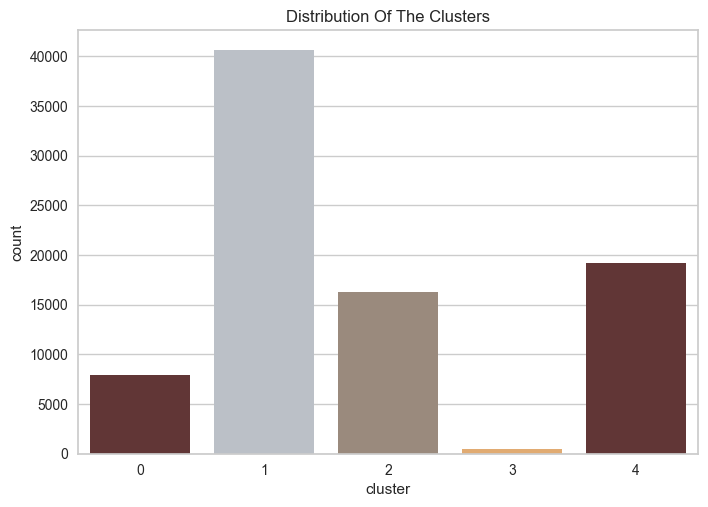

In [25]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=grouped_df["cluster"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

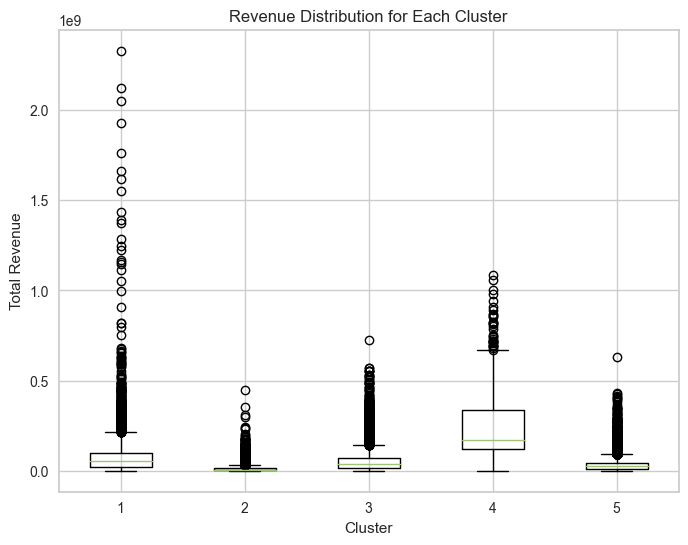

In [26]:
plt.figure(figsize=(8, 6))
plt.boxplot([grouped_df[grouped_df['cluster'] == i]['total_revenue'] for i in range(k)])
plt.xlabel('Cluster')
plt.ylabel('Total Revenue')
plt.title('Revenue Distribution for Each Cluster')
plt.show()


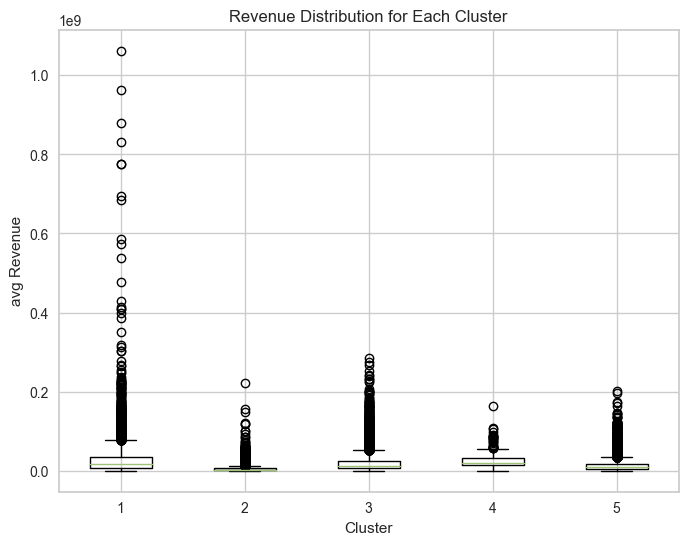

In [27]:
plt.figure(figsize=(8, 6))
plt.boxplot([grouped_df[grouped_df['cluster'] == i]['avg_revenue'] for i in range(k)])
plt.xlabel('Cluster')
plt.ylabel('avg Revenue')
plt.title('Revenue Distribution for Each Cluster')
plt.show()

In [28]:
cluster_mean_total_revenue = grouped_df.groupby('cluster')['total_revenue'].mean().sort_values()
cluster_mean_total_revenue

cluster
1    1.151807e+07
4    3.362034e+07
2    5.244060e+07
0    7.851710e+07
3    2.528274e+08
Name: total_revenue, dtype: float64

In [29]:
cluster_mean_avg_revenue = grouped_df.groupby('cluster')['avg_revenue'].mean().sort_values()
cluster_mean_avg_revenue

cluster
1    4.726798e+06
4    1.284516e+07
2    1.878959e+07
3    2.466354e+07
0    2.796531e+07
Name: avg_revenue, dtype: float64

# Preprocessing buat forecast

In [30]:
#table hari libur (sementara sebelum stretch nataru sama idul fitri)
id_holidays = holidays.ID(years=range(min(df.date.dt.year), max(df.date.dt.year)+1))

data = []

for day, event in id_holidays.items():
    data.append({'day': day, 'event': event})
    
df_holidays = pd.DataFrame(data)
df_holidays['day'] = pd.to_datetime(df_holidays['day'], format='%Y/%m/%d')

#cuti idul fitri
index = df_holidays.loc[df_holidays['event']=="Hari Raya Idul Fitri"].index
original_date = df_holidays.loc[index, 'day']
for date in original_date.values:
    date = pd.to_datetime(date)
#     print(date)
    for i in range(1, 4):
#         print(i)
        date_before = date - timedelta(days=i)
#         print(date_before)
        new_row = {'event': 'Cuti Hari Raya Idul Fitri', 'day': date_before}
#         print(new_row)
        df_holidays = df_holidays.append(new_row, ignore_index=True)

index = df_holidays.loc[df_holidays['event']=="Hari kedua dari Hari Raya Idul Fitri"].index
original_date = df_holidays.loc[index, 'day']
for date in original_date.values:
    date = pd.to_datetime(date)
#     print(date)
    for i in range(1, 3):
#         print(i)
        date_after = date + timedelta(days=i)
#         print(date_before)
        new_row = {'event': 'Cuti Hari Raya Idul Fitri', 'day': date_after}
#         print(new_row)
        df_holidays = df_holidays.append(new_row, ignore_index=True)

In [31]:
grouped_df['year'] = grouped_df['date'].dt.year
grouped_df['month'] = grouped_df['date'].dt.month
grouped_df['day'] = grouped_df['date'].dt.day
grouped_df['weekday'] = grouped_df['date'].dt.weekday
grouped_df['weekofmonth'] = grouped_df['date'].apply(lambda x: (x.day-1) // 7 + 1) # calculate week of month
grouped_df['hijri_year'] = grouped_df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().year)
grouped_df['hijri_month'] = grouped_df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().month)
grouped_df['hijri_day'] = grouped_df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().day)

In [39]:
grouped_df['is_holiday']=grouped_df['date'].apply(lambda x: 1 if x in df_holidays['day'].values else 0)

In [40]:
for i in range(5):
    print("cluster-",i)
    
    df1 = grouped_df.loc[grouped_df['cluster']==i].loc[:,['org','kode_org','des','kode_des']].value_counts()
    print(df1)
    

cluster- 0
org            kode_org  des          kode_des
MAKASSAR       893       BAU-BAU      921         559
BAU-BAU        921       MAKASSAR     893         541
MAKASSAR       893       SURABAYA     563         526
SURABAYA       563       MAKASSAR     893         514
SORONG         971       SURABAYA     563         373
JAYAPURA       974       SURABAYA     563         364
SURABAYA       563       SORONG       971         357
BAU-BAU        921       AMBON        946         348
AMBON          946       BAU-BAU      921         343
NUNUKAN        809       PARE-PARE    892         321
TARAKAN        808       PARE-PARE    892         312
BAU-BAU        921       SORONG       971         304
SORONG         971       BAU-BAU      921         304
PARE-PARE      892       TARAKAN      808         303
JAYAPURA       974       BAU-BAU      921         239
TANJUNG PRIOK  431       PULAU BATAM  256         219
BAU-BAU        921       JAYAPURA     974         218
AMBON          946      

# Test Implementasi Forecast Total Revenue ke Rute Terbanyak untuk Cluster (1) Terbanyak

In [61]:
data_train =  grouped_df.loc[grouped_df['cluster']==1]

In [62]:
# # Calculate z-scores for the 'total_revenue' column
# z_scores = (data_train['total_revenue'] - data_train['total_revenue'].mean()) / data_train['total_revenue'].std()

# # Set a threshold for the z-score to identify outliers (e.g., z-score > 3 or < -3)
# threshold = 3

# # Create a boolean mask to identify outliers
# outlier_mask = np.abs(z_scores) > threshold

# # Remove outliers from the DataFrame
# filtered_df = data_train[~outlier_mask]

# # Check the shape of the filtered DataFrame
# print("Shape of filtered DataFrame:", filtered_df.shape)

Shape of filtered DataFrame: (39851, 17)


<Axes: >

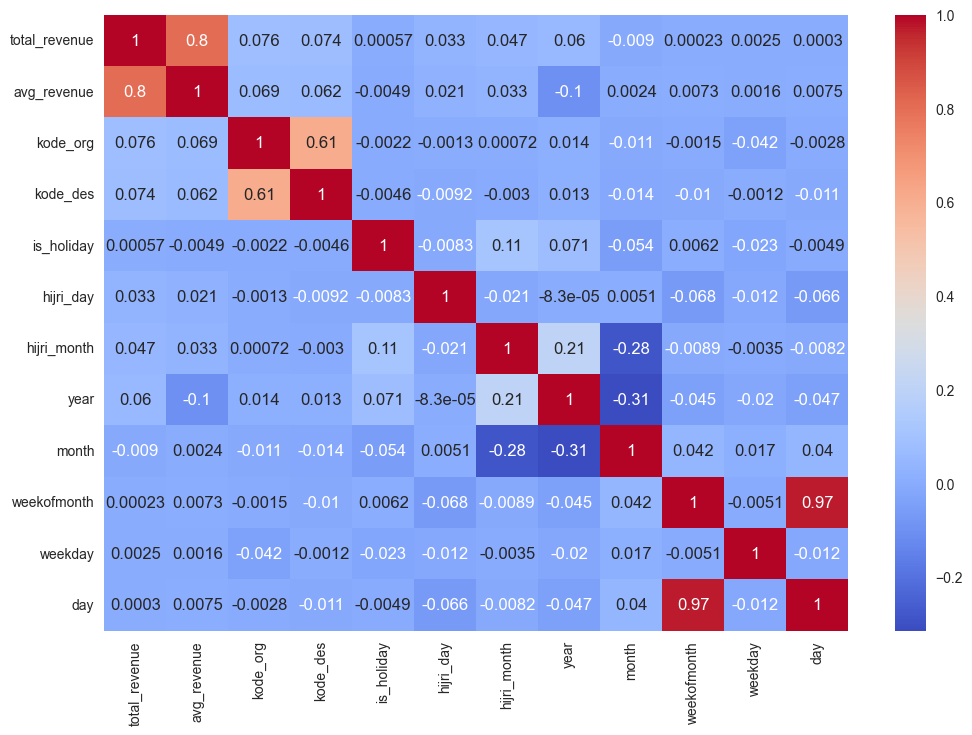

In [63]:


# Set the figure size
plt.figure(figsize=(12,8))

# Calculate the correlation matrix
corr_matrix = data_train[['total_revenue', 'avg_revenue','kode_org','kode_des', 'is_holiday','hijri_day', 'hijri_month', 'year', 'month', 'weekofmonth', 'weekday','day']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [56]:
data_test = grouped_df.loc[(grouped_df['kode_org'] == 563)&(grouped_df['kode_des'] == 431)]
steps = int(0.2*len(data_test))
positive_corr_columns = corr_matrix[(corr_matrix['total_revenue'] > 0)& (~corr_matrix.index.isin(['total_revenue', 'avg_revenue']))].index
X = data_test[positive_corr_columns]
y = data_test['total_revenue']
X_test  = X[-steps:]
y_test  = y[-steps:]
X_test

,kode_org,kode_des,is_holiday,hijri_day,hijri_month,year,weekofmonth,weekday,day
67595,563,431,0,25,7,2019,1,0,1
67655,563,431,0,26,7,2019,1,1,2
68087,563,431,0,3,8,2019,2,0,8
68131,563,431,0,4,8,2019,2,1,9
68208,563,431,0,5,8,2019,2,2,10
...,...,...,...,...,...,...,...,...,...
82741,563,431,0,8,10,2023,4,4,28
83168,563,431,0,14,10,2023,1,3,4
83417,563,431,0,17,10,2023,1,6,7
84109,563,431,0,25,10,2023,3,0,15


In [49]:
X_train = grouped_df.loc[grouped_df['cluster']==1][positive_corr_columns]
X_train

,kode_org,kode_des,is_holiday,hijri_day,hijri_month,year,weekofmonth,weekday,day
4,266,144,0,7,11,2015,4,5,22
6,144,266,0,10,11,2015,4,1,25
13,266,144,0,14,11,2015,5,5,29
15,144,266,0,17,11,2015,1,1,1
22,266,144,0,21,11,2015,1,5,5
...,...,...,...,...,...,...,...,...,...
84580,563,431,0,11,11,2023,5,2,31
84583,947,563,1,12,11,2023,1,3,1
84598,563,835,0,14,11,2023,1,5,3
84610,893,687,0,18,11,2023,1,2,7


In [50]:
y_train = grouped_df.loc[grouped_df['cluster']==1]['total_revenue']
y_train

4        11717000
6        11608000
13       16510500
15       15518500
22       20406500
           ...   
84580      461000
84583     1030000
84598     1641000
84610      194000
84614      326000
Name: total_revenue, Length: 40611, dtype: int64

In [51]:
import xgboost as xgb

# Create XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameters for tuning
params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid=params, cv=20)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the resulting score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}
Best score:  0.2403463487325291


In [57]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **grid_search.best_params_)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [58]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = xgb_model.score(X_test, y_test)
print("Mean squared error: ", mse)
print("R-squared: ", r2)

Mean squared error:  27424154180596.05
R-squared:  -0.31045946579933603


In [59]:
y_test.reset_index(drop=True)
y_test=pd.DataFrame(y_test)
y_test['y_pred']=y_pred
y_test = y_test.reset_index(drop=True)

<Axes: >

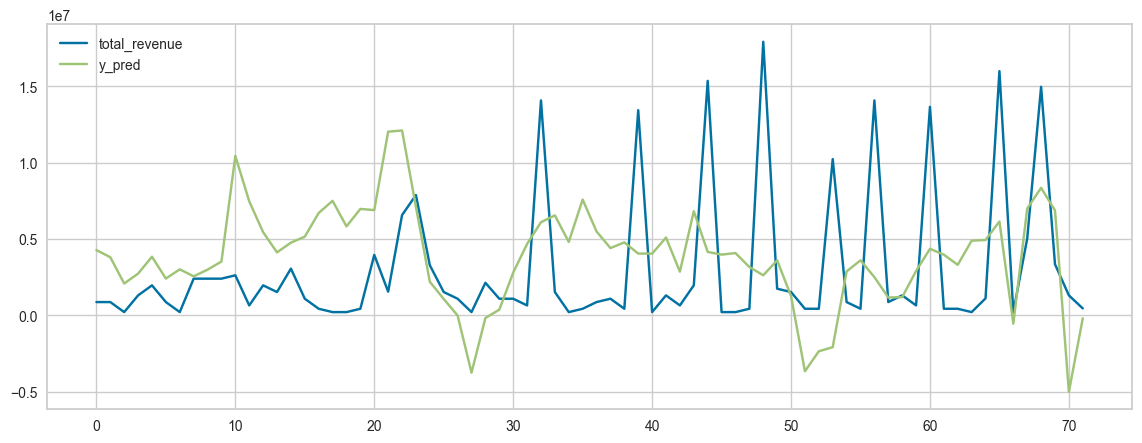

In [60]:
y_test.plot(figsize=(14,5))